In [1]:
import h5py
import argparse
import numpy as np
import chumpy as ch
import cPickle as pkl

from opendr.camera import ProjectPoints
from opendr.renderer import BoundaryRenderer, ColoredRenderer
from tqdm import tqdm

from util import im, mesh
from util.logger import log
from lib.frame import setup_frame_rays
from lib.rays import ray_objective
from lib.geometry import laplacian
from lib.ch import sp_dot
from models.smpl import Smpl
from models.bodyparts import faces_no_hands, regularize_laplace, regularize_model, regularize_symmetry

In [2]:
def get_cb(frame, base_smpl, camera, frustum):
    viz_mask = frame.mask / 255.
    base_smpl.pose[:] = frame.pose
    camera.t[:] = frame.trans
    camera.rt[:] = 0

    rn = ColoredRenderer(camera=camera, v=base_smpl, f=base_smpl.f, vc=np.ones_like(base_smpl),
                         frustum=frustum, bgcolor=0, num_channels=1)

    def cb(_):
        silh_diff = (rn.r - viz_mask + 1) / 2.
        im.show(silh_diff, waittime=1)

    return cb


def fit_consensus(frames, base_smpl, camera, frustum, model_data, nohands, icp_count, naked, display):
    if nohands:
        faces = faces_no_hands(base_smpl.f)
    else:
        faces = base_smpl.f

    vis_rn_b = BoundaryRenderer(camera=camera, frustum=frustum, f=faces, num_channels=1)
    vis_rn_m = ColoredRenderer(camera=camera, frustum=frustum, f=faces, vc=np.zeros_like(base_smpl), bgcolor=1,
                               num_channels=1)

    model_template = Smpl(model_data)
    model_template.betas[:] = base_smpl.betas.r

    g_laplace = regularize_laplace()
    g_model = regularize_model()
    g_symmetry = regularize_symmetry()

    for step, (w_laplace, w_model, w_symmetry, sigma) in enumerate(zip(
            np.linspace(6.5, 4.0, icp_count) if naked else np.linspace(4.0, 2.0, icp_count),
            np.linspace(0.9, 0.6, icp_count) if naked else np.linspace(0.6, 0.3, icp_count),
            np.linspace(3.6, 1.8, icp_count),
            np.linspace(0.06, 0.003, icp_count),
    )):
        log.info('# Step {}'.format(step))

        L = laplacian(model_template.r, base_smpl.f)
        delta = L.dot(model_template.r)

        w_laplace *= g_laplace.reshape(-1, 1)
        w_model *= g_model.reshape(-1, 1)
        w_symmetry *= g_symmetry.reshape(-1, 1)

        E = {
            'laplace': (sp_dot(L, base_smpl.v_shaped_personal) - delta) * w_laplace,
            'model': (base_smpl.v_shaped_personal - model_template) * w_model,
            'symmetry': (base_smpl.v_personal + np.array([1, -1, -1])
                         * base_smpl.v_personal[model_data['vert_sym_idxs']]) * w_symmetry,
        }

        log.info('## Matching rays with contours')
        for current, f in enumerate(tqdm(frames)):
            E['silh_{}'.format(current)] = ray_objective(f, sigma, base_smpl, camera, vis_rn_b, vis_rn_m)

        log.info('## Run optimization')
        ch.minimize(
            E,
            [base_smpl.v_personal, model_template.betas],
            method='dogleg',
            options={'maxiter': 15, 'e_3': 0.001},
            callback=get_cb(frames[0], base_smpl, camera, frustum) if display else None
        )

In [3]:
ipath = "./dataset/female-3-sport/"
opath = "./output/"
pose_file = ipath + "reconstructed_poses.hdf5"
masks_file = ipath + "masks.hdf5"
camera_file = ipath + "camera.pkl"
out = opath + "consensus.pkl"
obj_out = opath + "consensus.obj" 
num = 120
icp_count = 3
model_file = "vendor/smpl/models/basicmodel_m_lbs_10_207_0_v1.0.0.pkl"
first_frame = 0
last_frame = 2000
nohands = None
naked = None
display = True

In [4]:
# load data
with open(model_file, 'rb') as fp:
    model_data = pkl.load(fp)

with open(camera_file, 'rb') as fp:
    camera_data = pkl.load(fp)

pose_data = h5py.File(pose_file, 'r')
poses = pose_data['pose'][first_frame:last_frame]
trans = pose_data['trans'][first_frame:last_frame]
masks = h5py.File(masks_file, 'r')['masks'][first_frame:last_frame]
num_frames = masks.shape[0]

indices_consensus = np.ceil(np.arange(num) * num_frames * 1. / num).astype(np.int)

In [5]:
# init
base_smpl = Smpl(model_data)
base_smpl.betas[:] = np.array(pose_data['betas'], dtype=np.float32)

camera = ProjectPoints(t=np.zeros(3), rt=np.zeros(3), c=camera_data['camera_c'],
                       f=camera_data['camera_f'], k=camera_data['camera_k'], v=base_smpl)
camera_t = camera_data['camera_t']
camera_rt = camera_data['camera_rt']
frustum = {'near': 0.1, 'far': 1000., 'width': int(camera_data['width']), 'height': int(camera_data['height'])}
frames = []

for i in indices_consensus:
    log.info('Set up frame {}...'.format(i))

    mask = np.array(masks[i] * 255, dtype=np.uint8)
    pose_i = np.array(poses[i], dtype=np.float32)
    trans_i = np.array(trans[i], dtype=np.float32)

    frames.append(setup_frame_rays(base_smpl, camera, camera_t, camera_rt, pose_i, trans_i, mask))

log.info('Set up complete.')

2018-12-20 01:26:58,323 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 0...
2018-12-20 01:26:58,864 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 5...
2018-12-20 01:26:58,897 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 9...
2018-12-20 01:26:58,935 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 13...
2018-12-20 01:26:58,973 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 18...
2018-12-20 01:26:59,004 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 22...
2018-12-20 01:26:59,034 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 26...
2018-12-20 01:26:59,068 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 30...
2018-12-20 01:26:59,100 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 35...
2018-12-20 01:26:59,134 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 39...
2018-12-20 01:26:59,164 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 43...
2018-12-20 01:26:59,200 [<ipython-i

2018-12-20 01:27:02,749 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 397...
2018-12-20 01:27:02,802 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 401...
2018-12-20 01:27:02,850 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 405...
2018-12-20 01:27:02,900 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 409...
2018-12-20 01:27:02,952 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 414...
2018-12-20 01:27:03,004 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 418...
2018-12-20 01:27:03,054 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 422...
2018-12-20 01:27:03,104 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 426...
2018-12-20 01:27:03,155 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 431...
2018-12-20 01:27:03,254 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 435...
2018-12-20 01:27:03,302 [<ipython-input-5-2ea240d3e577>:<module>:13] Set up frame 439...
2018-12-20 01:27:03,3

2018-12-20 01:29:27,161 [<ipython-input-6-05ee24501251>:<module>:1] Begin consensus fit...
2018-12-20 01:29:27,265 [<ipython-input-2-361b26327425>:fit_consensus:40] # Step 0
2018-12-20 01:29:27,350 [<ipython-input-2-361b26327425>:fit_consensus:56] ## Matching rays with contours
  0%|          | 0/120 [00:00<?, ?it/s]lib/rays.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  valid_rays = dist[np.vstack((ray_matches, range(dist.shape[1]))).tolist()] < 0.12
lib/rays.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  valid_verts = dist[n

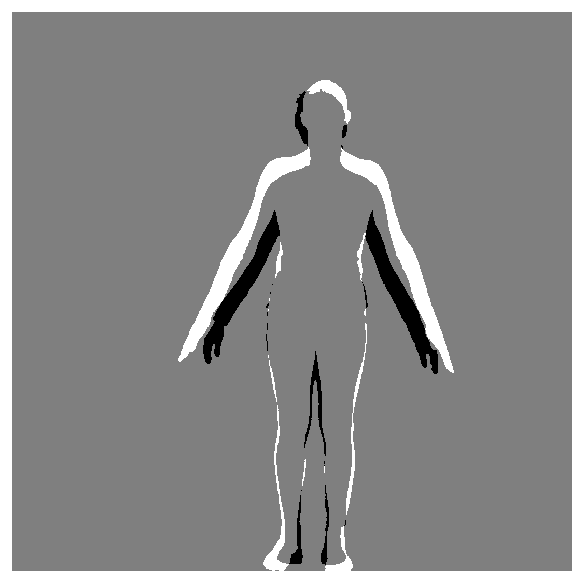

2.37e+02 | laplace: 4.12e-25 | model: 8.49e-28 | silh_0: 2.38e+00 | silh_1: 2.35e+00 | silh_10: 1.90e+00 | silh_100: 2.10e+00 | silh_101: 1.72e+00 | silh_102: 1.29e+00 | silh_103: 1.24e+00 | silh_104: 1.17e+00 | silh_105: 1.35e+00 | silh_106: 1.17e+00 | silh_107: 1.56e+00 | silh_108: 2.75e+00 | silh_109: 2.14e+00 | silh_11: 1.59e+00 | silh_110: 2.15e+00 | silh_111: 2.25e+00 | silh_112: 2.25e+00 | silh_113: 2.39e+00 | silh_114: 2.37e+00 | silh_115: 2.43e+00 | silh_116: 2.41e+00 | silh_117: 2.23e+00 | silh_118: 2.18e+00 | silh_119: 2.20e+00 | silh_12: 1.53e+00 | silh_13: 1.39e+00 | silh_14: 1.39e+00 | silh_15: 1.52e+00 | silh_16: 1.89e+00 | silh_17: 2.19e+00 | silh_18: 2.18e+00 | silh_19: 2.41e+00 | silh_2: 2.25e+00 | silh_20: 2.49e+00 | silh_21: 2.22e+00 | silh_22: 2.01e+00 | silh_23: 1.88e+00 | silh_24: 1.76e+00 | silh_25: 1.18e+00 | silh_26: 8.93e-01 | silh_27: 1.09e+00 | silh_28: 1.31e+00 | silh_29: 1.75e+00 | silh_3: 2.17e+00 | silh_30: 2.30e+00 | silh_31: 2.03e+00 | silh_32: 2.01e+

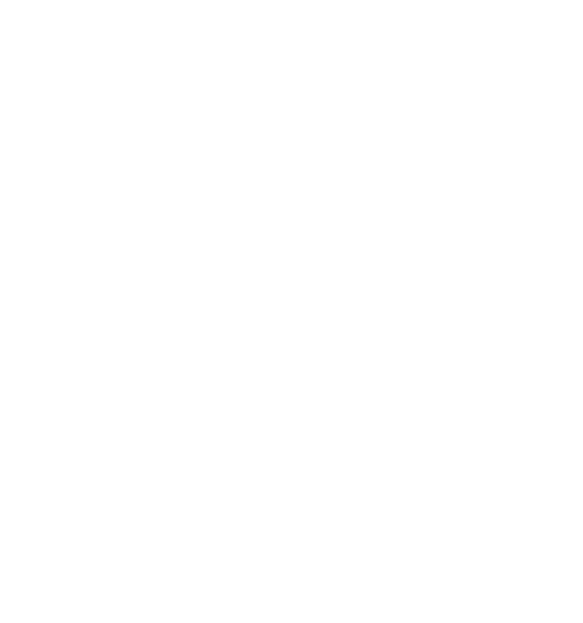

1.53e+02 | laplace: 3.65e+00 | model: 2.48e+00 | silh_0: 1.51e+00 | silh_1: 1.53e+00 | silh_10: 1.11e+00 | silh_100: 1.33e+00 | silh_101: 1.03e+00 | silh_102: 7.97e-01 | silh_103: 6.05e-01 | silh_104: 5.36e-01 | silh_105: 7.95e-01 | silh_106: 7.91e-01 | silh_107: 9.76e-01 | silh_108: 2.23e+00 | silh_109: 1.41e+00 | silh_11: 9.69e-01 | silh_110: 1.45e+00 | silh_111: 1.51e+00 | silh_112: 1.46e+00 | silh_113: 1.41e+00 | silh_114: 1.43e+00 | silh_115: 1.44e+00 | silh_116: 1.48e+00 | silh_117: 1.33e+00 | silh_118: 1.34e+00 | silh_119: 1.34e+00 | silh_12: 6.66e-01 | silh_13: 6.40e-01 | silh_14: 8.32e-01 | silh_15: 8.68e-01 | silh_16: 1.09e+00 | silh_17: 1.35e+00 | silh_18: 1.26e+00 | silh_19: 1.48e+00 | silh_2: 1.45e+00 | silh_20: 1.50e+00 | silh_21: 1.38e+00 | silh_22: 1.26e+00 | silh_23: 1.27e+00 | silh_24: 1.15e+00 | silh_25: 5.17e-01 | silh_26: 3.85e-01 | silh_27: 6.07e-01 | silh_28: 7.15e-01 | silh_29: 1.28e+00 | silh_3: 1.36e+00 | silh_30: 1.67e+00 | silh_31: 1.31e+00 | silh_32: 1.29e+

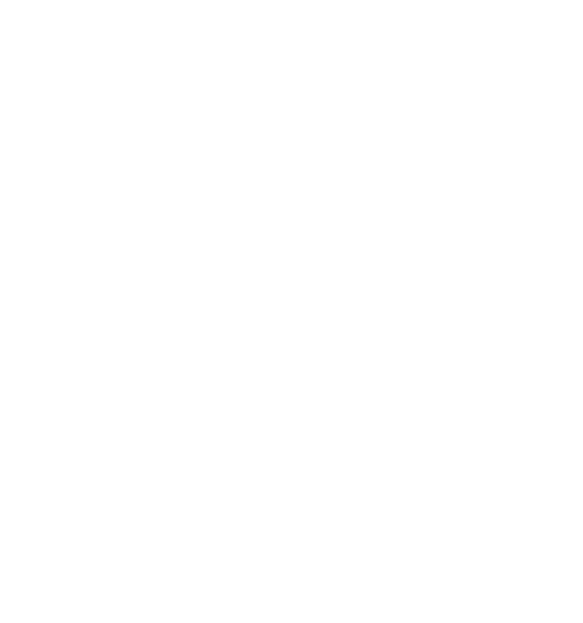

1.48e+02 | laplace: 3.60e+00 | model: 2.76e+00 | silh_0: 1.42e+00 | silh_1: 1.42e+00 | silh_10: 1.11e+00 | silh_100: 1.32e+00 | silh_101: 1.04e+00 | silh_102: 8.21e-01 | silh_103: 6.04e-01 | silh_104: 5.20e-01 | silh_105: 7.91e-01 | silh_106: 8.05e-01 | silh_107: 9.78e-01 | silh_108: 2.20e+00 | silh_109: 1.35e+00 | silh_11: 9.88e-01 | silh_110: 1.38e+00 | silh_111: 1.42e+00 | silh_112: 1.39e+00 | silh_113: 1.33e+00 | silh_114: 1.34e+00 | silh_115: 1.35e+00 | silh_116: 1.38e+00 | silh_117: 1.24e+00 | silh_118: 1.25e+00 | silh_119: 1.25e+00 | silh_12: 6.41e-01 | silh_13: 6.34e-01 | silh_14: 8.37e-01 | silh_15: 8.68e-01 | silh_16: 1.05e+00 | silh_17: 1.29e+00 | silh_18: 1.20e+00 | silh_19: 1.40e+00 | silh_2: 1.35e+00 | silh_20: 1.42e+00 | silh_21: 1.29e+00 | silh_22: 1.22e+00 | silh_23: 1.26e+00 | silh_24: 1.17e+00 | silh_25: 5.04e-01 | silh_26: 3.76e-01 | silh_27: 6.20e-01 | silh_28: 7.27e-01 | silh_29: 1.23e+00 | silh_3: 1.25e+00 | silh_30: 1.63e+00 | silh_31: 1.25e+00 | silh_32: 1.22e+

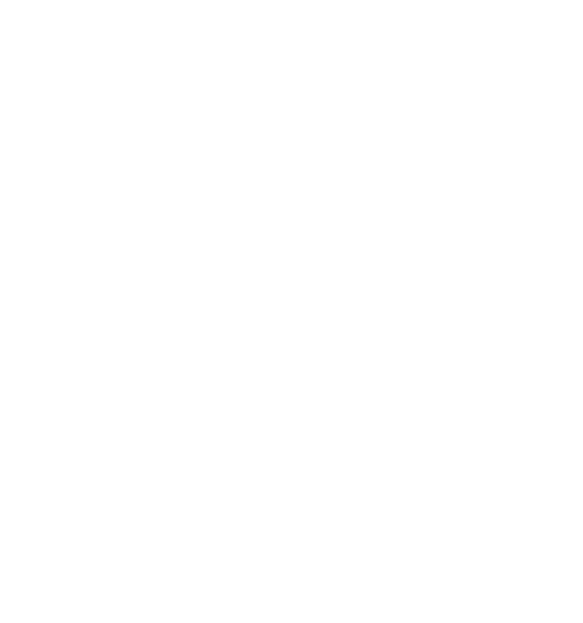

1.47e+02 | laplace: 3.73e+00 | model: 2.86e+00 | silh_0: 1.41e+00 | silh_1: 1.42e+00 | silh_10: 1.12e+00 | silh_100: 1.31e+00 | silh_101: 1.05e+00 | silh_102: 8.31e-01 | silh_103: 6.07e-01 | silh_104: 5.19e-01 | silh_105: 7.90e-01 | silh_106: 8.08e-01 | silh_107: 9.80e-01 | silh_108: 2.21e+00 | silh_109: 1.35e+00 | silh_11: 9.96e-01 | silh_110: 1.38e+00 | silh_111: 1.41e+00 | silh_112: 1.38e+00 | silh_113: 1.31e+00 | silh_114: 1.33e+00 | silh_115: 1.33e+00 | silh_116: 1.37e+00 | silh_117: 1.23e+00 | silh_118: 1.24e+00 | silh_119: 1.24e+00 | silh_12: 6.38e-01 | silh_13: 6.34e-01 | silh_14: 8.41e-01 | silh_15: 8.73e-01 | silh_16: 1.05e+00 | silh_17: 1.28e+00 | silh_18: 1.19e+00 | silh_19: 1.39e+00 | silh_2: 1.34e+00 | silh_20: 1.40e+00 | silh_21: 1.28e+00 | silh_22: 1.22e+00 | silh_23: 1.26e+00 | silh_24: 1.18e+00 | silh_25: 5.03e-01 | silh_26: 3.76e-01 | silh_27: 6.23e-01 | silh_28: 7.31e-01 | silh_29: 1.23e+00 | silh_3: 1.24e+00 | silh_30: 1.63e+00 | silh_31: 1.25e+00 | silh_32: 1.22e+

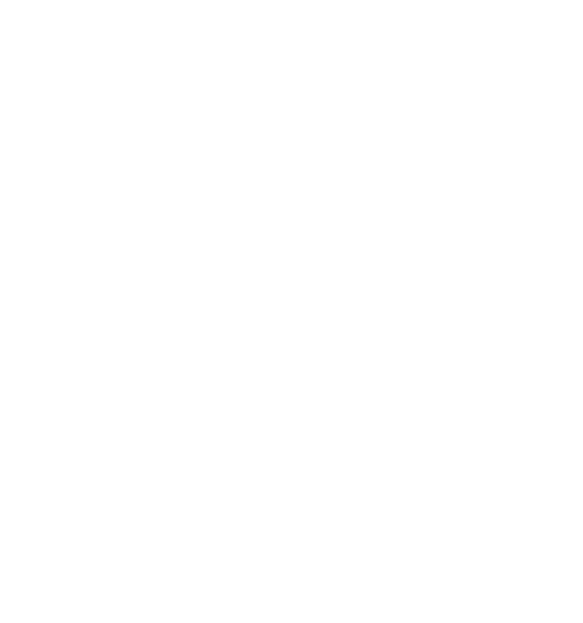

1.47e+02 | laplace: 3.79e+00 | model: 2.88e+00 | silh_0: 1.41e+00 | silh_1: 1.43e+00 | silh_10: 1.12e+00 | silh_100: 1.31e+00 | silh_101: 1.05e+00 | silh_102: 8.35e-01 | silh_103: 6.08e-01 | silh_104: 5.19e-01 | silh_105: 7.90e-01 | silh_106: 8.09e-01 | silh_107: 9.81e-01 | silh_108: 2.21e+00 | silh_109: 1.35e+00 | silh_11: 9.99e-01 | silh_110: 1.37e+00 | silh_111: 1.41e+00 | silh_112: 1.37e+00 | silh_113: 1.31e+00 | silh_114: 1.32e+00 | silh_115: 1.33e+00 | silh_116: 1.36e+00 | silh_117: 1.23e+00 | silh_118: 1.23e+00 | silh_119: 1.24e+00 | silh_12: 6.37e-01 | silh_13: 6.34e-01 | silh_14: 8.42e-01 | silh_15: 8.74e-01 | silh_16: 1.05e+00 | silh_17: 1.28e+00 | silh_18: 1.19e+00 | silh_19: 1.39e+00 | silh_2: 1.34e+00 | silh_20: 1.40e+00 | silh_21: 1.28e+00 | silh_22: 1.22e+00 | silh_23: 1.26e+00 | silh_24: 1.18e+00 | silh_25: 5.03e-01 | silh_26: 3.76e-01 | silh_27: 6.24e-01 | silh_28: 7.33e-01 | silh_29: 1.23e+00 | silh_3: 1.24e+00 | silh_30: 1.63e+00 | silh_31: 1.24e+00 | silh_32: 1.21e+

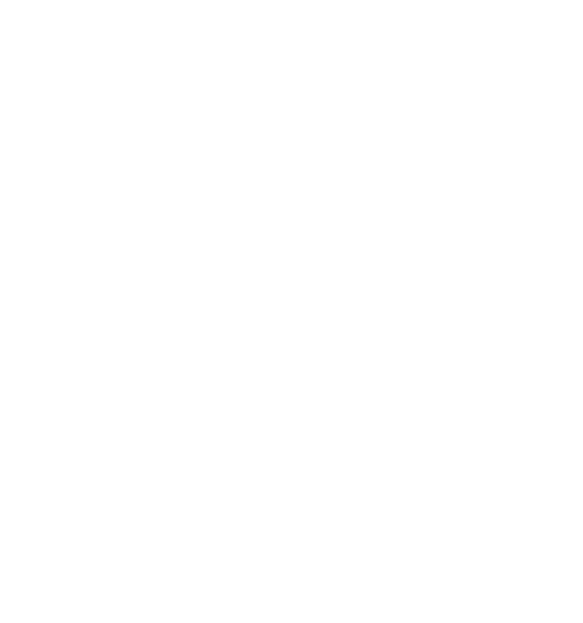

9.76e+01 | laplace: 2.57e+00 | model: 1.62e+00 | silh_0: 9.11e-01 | silh_1: 8.82e-01 | silh_10: 7.60e-01 | silh_100: 8.65e-01 | silh_101: 7.83e-01 | silh_102: 6.10e-01 | silh_103: 4.17e-01 | silh_104: 3.74e-01 | silh_105: 5.37e-01 | silh_106: 5.62e-01 | silh_107: 6.31e-01 | silh_108: 1.28e+00 | silh_109: 8.64e-01 | silh_11: 7.05e-01 | silh_110: 8.43e-01 | silh_111: 9.03e-01 | silh_112: 8.93e-01 | silh_113: 8.73e-01 | silh_114: 8.65e-01 | silh_115: 8.82e-01 | silh_116: 9.06e-01 | silh_117: 8.20e-01 | silh_118: 8.02e-01 | silh_119: 8.05e-01 | silh_12: 4.67e-01 | silh_13: 5.65e-01 | silh_14: 7.89e-01 | silh_15: 6.32e-01 | silh_16: 6.60e-01 | silh_17: 7.75e-01 | silh_18: 7.69e-01 | silh_19: 9.25e-01 | silh_2: 8.36e-01 | silh_20: 9.22e-01 | silh_21: 8.16e-01 | silh_22: 8.06e-01 | silh_23: 9.12e-01 | silh_24: 9.29e-01 | silh_25: 3.97e-01 | silh_26: 2.78e-01 | silh_27: 5.05e-01 | silh_28: 4.94e-01 | silh_29: 8.11e-01 | silh_3: 7.89e-01 | silh_30: 1.10e+00 | silh_31: 8.45e-01 | silh_32: 7.73e-

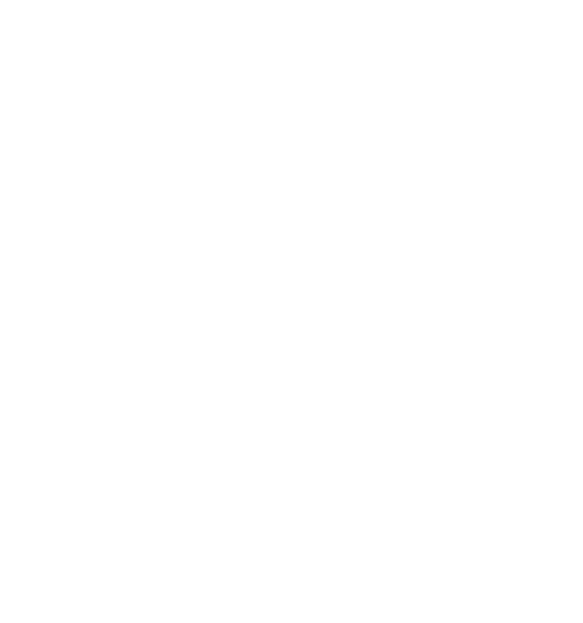

8.26e+01 | laplace: 3.49e+00 | model: 2.27e+00 | silh_0: 7.00e-01 | silh_1: 6.67e-01 | silh_10: 6.44e-01 | silh_100: 7.15e-01 | silh_101: 6.48e-01 | silh_102: 4.97e-01 | silh_103: 3.40e-01 | silh_104: 3.22e-01 | silh_105: 5.17e-01 | silh_106: 5.88e-01 | silh_107: 6.44e-01 | silh_108: 1.26e+00 | silh_109: 6.94e-01 | silh_11: 5.95e-01 | silh_110: 6.85e-01 | silh_111: 7.19e-01 | silh_112: 6.96e-01 | silh_113: 6.53e-01 | silh_114: 6.48e-01 | silh_115: 6.57e-01 | silh_116: 6.93e-01 | silh_117: 6.08e-01 | silh_118: 6.03e-01 | silh_119: 6.03e-01 | silh_12: 4.13e-01 | silh_13: 5.05e-01 | silh_14: 7.17e-01 | silh_15: 5.82e-01 | silh_16: 5.30e-01 | silh_17: 6.00e-01 | silh_18: 6.11e-01 | silh_19: 7.29e-01 | silh_2: 6.25e-01 | silh_20: 7.02e-01 | silh_21: 6.68e-01 | silh_22: 6.98e-01 | silh_23: 7.98e-01 | silh_24: 8.07e-01 | silh_25: 3.28e-01 | silh_26: 2.43e-01 | silh_27: 4.67e-01 | silh_28: 4.68e-01 | silh_29: 7.67e-01 | silh_3: 5.85e-01 | silh_30: 9.80e-01 | silh_31: 6.79e-01 | silh_32: 6.04e-

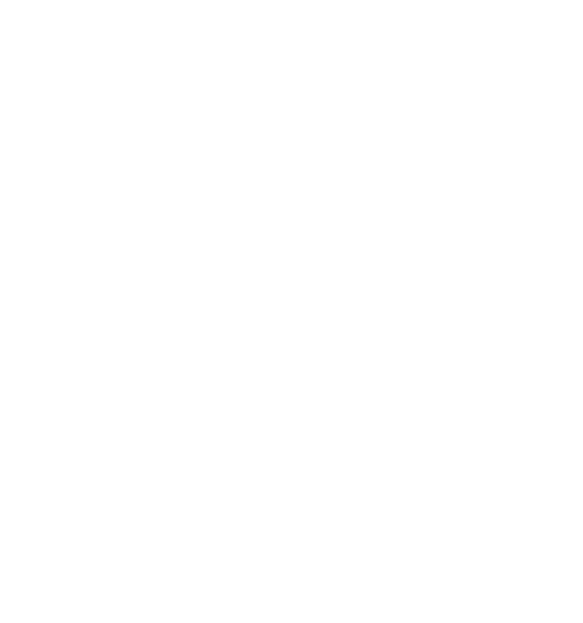

8.17e+01 | laplace: 3.70e+00 | model: 2.42e+00 | silh_0: 6.89e-01 | silh_1: 6.44e-01 | silh_10: 6.41e-01 | silh_100: 7.17e-01 | silh_101: 6.48e-01 | silh_102: 4.89e-01 | silh_103: 3.34e-01 | silh_104: 3.16e-01 | silh_105: 5.18e-01 | silh_106: 6.00e-01 | silh_107: 6.57e-01 | silh_108: 1.26e+00 | silh_109: 6.71e-01 | silh_11: 5.87e-01 | silh_110: 6.54e-01 | silh_111: 6.91e-01 | silh_112: 6.71e-01 | silh_113: 6.38e-01 | silh_114: 6.37e-01 | silh_115: 6.45e-01 | silh_116: 6.74e-01 | silh_117: 5.84e-01 | silh_118: 5.76e-01 | silh_119: 5.80e-01 | silh_12: 4.08e-01 | silh_13: 5.00e-01 | silh_14: 7.11e-01 | silh_15: 5.83e-01 | silh_16: 5.16e-01 | silh_17: 5.78e-01 | silh_18: 5.87e-01 | silh_19: 7.09e-01 | silh_2: 6.02e-01 | silh_20: 6.88e-01 | silh_21: 6.64e-01 | silh_22: 6.98e-01 | silh_23: 8.01e-01 | silh_24: 7.99e-01 | silh_25: 3.23e-01 | silh_26: 2.39e-01 | silh_27: 4.67e-01 | silh_28: 4.74e-01 | silh_29: 7.72e-01 | silh_3: 5.55e-01 | silh_30: 9.72e-01 | silh_31: 6.58e-01 | silh_32: 5.76e-

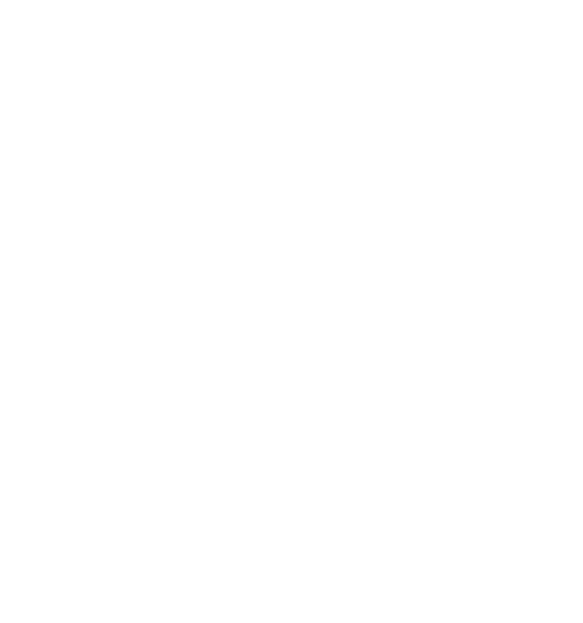

8.15e+01 | laplace: 3.83e+00 | model: 2.46e+00 | silh_0: 6.83e-01 | silh_1: 6.37e-01 | silh_10: 6.44e-01 | silh_100: 7.20e-01 | silh_101: 6.49e-01 | silh_102: 4.88e-01 | silh_103: 3.33e-01 | silh_104: 3.14e-01 | silh_105: 5.19e-01 | silh_106: 6.04e-01 | silh_107: 6.62e-01 | silh_108: 1.26e+00 | silh_109: 6.62e-01 | silh_11: 5.86e-01 | silh_110: 6.43e-01 | silh_111: 6.82e-01 | silh_112: 6.63e-01 | silh_113: 6.32e-01 | silh_114: 6.33e-01 | silh_115: 6.41e-01 | silh_116: 6.69e-01 | silh_117: 5.77e-01 | silh_118: 5.67e-01 | silh_119: 5.73e-01 | silh_12: 4.07e-01 | silh_13: 5.00e-01 | silh_14: 7.09e-01 | silh_15: 5.86e-01 | silh_16: 5.14e-01 | silh_17: 5.71e-01 | silh_18: 5.81e-01 | silh_19: 7.02e-01 | silh_2: 5.94e-01 | silh_20: 6.81e-01 | silh_21: 6.65e-01 | silh_22: 7.00e-01 | silh_23: 8.03e-01 | silh_24: 7.98e-01 | silh_25: 3.22e-01 | silh_26: 2.39e-01 | silh_27: 4.67e-01 | silh_28: 4.77e-01 | silh_29: 7.73e-01 | silh_3: 5.46e-01 | silh_30: 9.67e-01 | silh_31: 6.50e-01 | silh_32: 5.66e-

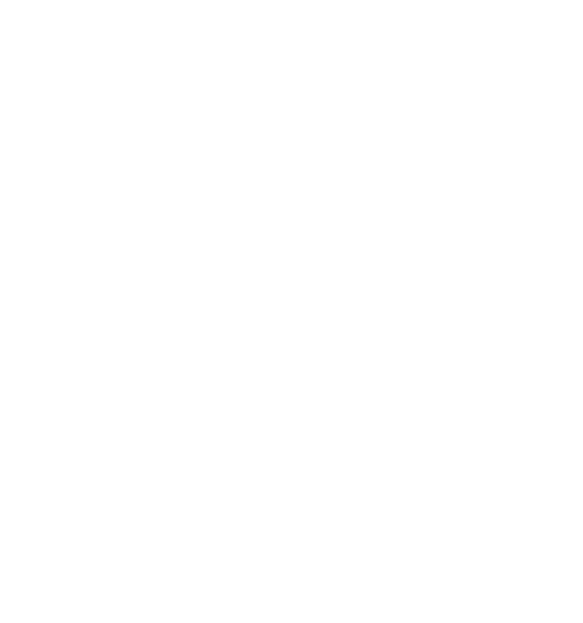

8.14e+01 | laplace: 3.91e+00 | model: 2.48e+00 | silh_0: 6.79e-01 | silh_1: 6.32e-01 | silh_10: 6.47e-01 | silh_100: 7.23e-01 | silh_101: 6.52e-01 | silh_102: 4.90e-01 | silh_103: 3.33e-01 | silh_104: 3.14e-01 | silh_105: 5.19e-01 | silh_106: 6.05e-01 | silh_107: 6.64e-01 | silh_108: 1.26e+00 | silh_109: 6.58e-01 | silh_11: 5.87e-01 | silh_110: 6.36e-01 | silh_111: 6.75e-01 | silh_112: 6.56e-01 | silh_113: 6.29e-01 | silh_114: 6.32e-01 | silh_115: 6.39e-01 | silh_116: 6.65e-01 | silh_117: 5.71e-01 | silh_118: 5.60e-01 | silh_119: 5.68e-01 | silh_12: 4.06e-01 | silh_13: 5.00e-01 | silh_14: 7.09e-01 | silh_15: 5.87e-01 | silh_16: 5.13e-01 | silh_17: 5.66e-01 | silh_18: 5.76e-01 | silh_19: 6.98e-01 | silh_2: 5.89e-01 | silh_20: 6.76e-01 | silh_21: 6.66e-01 | silh_22: 7.00e-01 | silh_23: 8.06e-01 | silh_24: 8.00e-01 | silh_25: 3.21e-01 | silh_26: 2.38e-01 | silh_27: 4.67e-01 | silh_28: 4.78e-01 | silh_29: 7.73e-01 | silh_3: 5.38e-01 | silh_30: 9.64e-01 | silh_31: 6.44e-01 | silh_32: 5.59e-

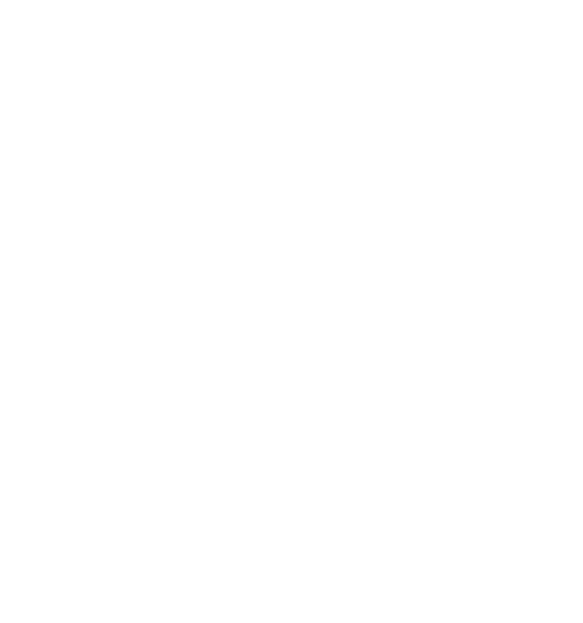

8.12e+01 | laplace: 3.98e+00 | model: 2.48e+00 | silh_0: 6.75e-01 | silh_1: 6.28e-01 | silh_10: 6.51e-01 | silh_100: 7.25e-01 | silh_101: 6.55e-01 | silh_102: 4.93e-01 | silh_103: 3.33e-01 | silh_104: 3.14e-01 | silh_105: 5.19e-01 | silh_106: 6.06e-01 | silh_107: 6.65e-01 | silh_108: 1.26e+00 | silh_109: 6.54e-01 | silh_11: 5.88e-01 | silh_110: 6.30e-01 | silh_111: 6.69e-01 | silh_112: 6.50e-01 | silh_113: 6.25e-01 | silh_114: 6.31e-01 | silh_115: 6.37e-01 | silh_116: 6.61e-01 | silh_117: 5.66e-01 | silh_118: 5.53e-01 | silh_119: 5.62e-01 | silh_12: 4.06e-01 | silh_13: 5.00e-01 | silh_14: 7.09e-01 | silh_15: 5.88e-01 | silh_16: 5.13e-01 | silh_17: 5.63e-01 | silh_18: 5.72e-01 | silh_19: 6.94e-01 | silh_2: 5.84e-01 | silh_20: 6.73e-01 | silh_21: 6.66e-01 | silh_22: 7.00e-01 | silh_23: 8.09e-01 | silh_24: 8.02e-01 | silh_25: 3.21e-01 | silh_26: 2.38e-01 | silh_27: 4.68e-01 | silh_28: 4.79e-01 | silh_29: 7.73e-01 | silh_3: 5.31e-01 | silh_30: 9.61e-01 | silh_31: 6.40e-01 | silh_32: 5.54e-

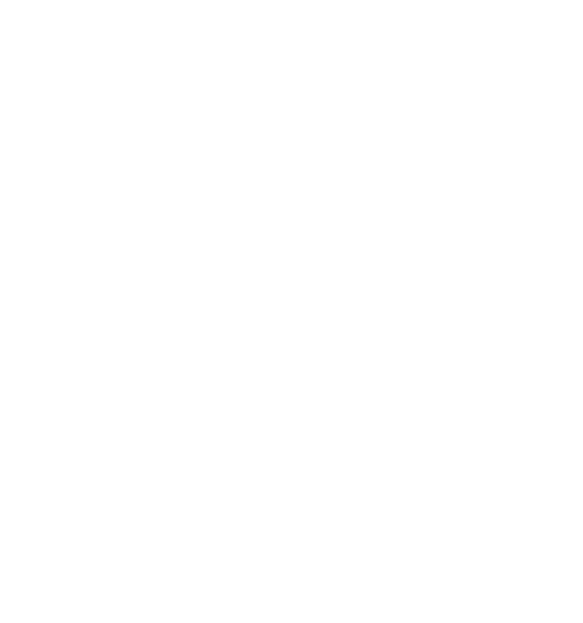

8.11e+01 | laplace: 4.03e+00 | model: 2.48e+00 | silh_0: 6.71e-01 | silh_1: 6.24e-01 | silh_10: 6.55e-01 | silh_100: 7.26e-01 | silh_101: 6.57e-01 | silh_102: 4.96e-01 | silh_103: 3.34e-01 | silh_104: 3.14e-01 | silh_105: 5.19e-01 | silh_106: 6.06e-01 | silh_107: 6.66e-01 | silh_108: 1.26e+00 | silh_109: 6.53e-01 | silh_11: 5.89e-01 | silh_110: 6.27e-01 | silh_111: 6.65e-01 | silh_112: 6.46e-01 | silh_113: 6.22e-01 | silh_114: 6.29e-01 | silh_115: 6.35e-01 | silh_116: 6.58e-01 | silh_117: 5.61e-01 | silh_118: 5.47e-01 | silh_119: 5.58e-01 | silh_12: 4.06e-01 | silh_13: 5.00e-01 | silh_14: 7.08e-01 | silh_15: 5.89e-01 | silh_16: 5.14e-01 | silh_17: 5.60e-01 | silh_18: 5.70e-01 | silh_19: 6.92e-01 | silh_2: 5.80e-01 | silh_20: 6.69e-01 | silh_21: 6.65e-01 | silh_22: 6.99e-01 | silh_23: 8.12e-01 | silh_24: 8.05e-01 | silh_25: 3.21e-01 | silh_26: 2.38e-01 | silh_27: 4.68e-01 | silh_28: 4.80e-01 | silh_29: 7.73e-01 | silh_3: 5.26e-01 | silh_30: 9.60e-01 | silh_31: 6.38e-01 | silh_32: 5.50e-

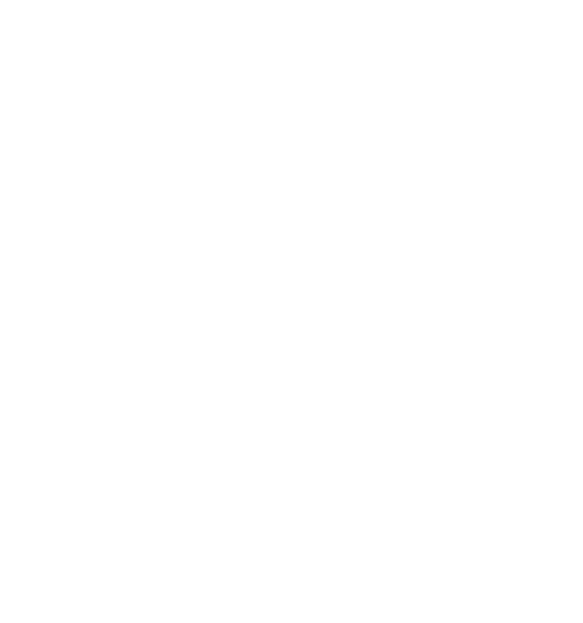

8.10e+01 | laplace: 4.07e+00 | model: 2.48e+00 | silh_0: 6.68e-01 | silh_1: 6.21e-01 | silh_10: 6.58e-01 | silh_100: 7.26e-01 | silh_101: 6.58e-01 | silh_102: 5.00e-01 | silh_103: 3.35e-01 | silh_104: 3.14e-01 | silh_105: 5.19e-01 | silh_106: 6.07e-01 | silh_107: 6.67e-01 | silh_108: 1.26e+00 | silh_109: 6.51e-01 | silh_11: 5.91e-01 | silh_110: 6.25e-01 | silh_111: 6.63e-01 | silh_112: 6.43e-01 | silh_113: 6.19e-01 | silh_114: 6.28e-01 | silh_115: 6.33e-01 | silh_116: 6.56e-01 | silh_117: 5.58e-01 | silh_118: 5.44e-01 | silh_119: 5.55e-01 | silh_12: 4.06e-01 | silh_13: 5.00e-01 | silh_14: 7.08e-01 | silh_15: 5.90e-01 | silh_16: 5.14e-01 | silh_17: 5.59e-01 | silh_18: 5.69e-01 | silh_19: 6.92e-01 | silh_2: 5.76e-01 | silh_20: 6.67e-01 | silh_21: 6.64e-01 | silh_22: 6.98e-01 | silh_23: 8.14e-01 | silh_24: 8.09e-01 | silh_25: 3.20e-01 | silh_26: 2.38e-01 | silh_27: 4.68e-01 | silh_28: 4.80e-01 | silh_29: 7.72e-01 | silh_3: 5.22e-01 | silh_30: 9.59e-01 | silh_31: 6.36e-01 | silh_32: 5.48e-

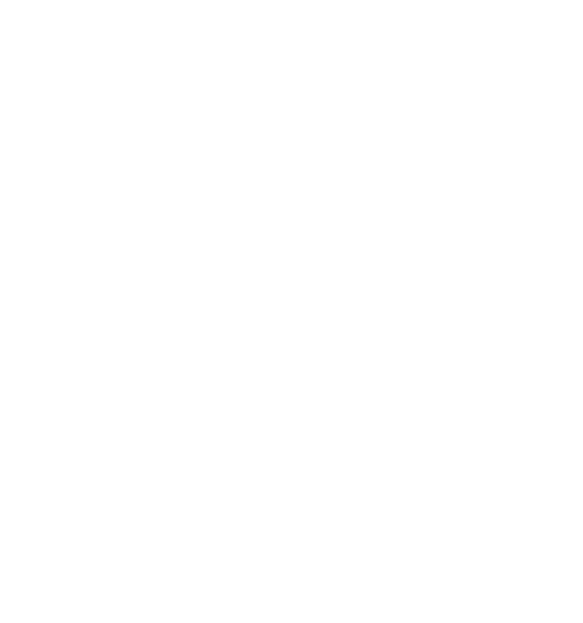

1.01e+01 | laplace: 1.86e+00 | model: 1.10e+00 | silh_0: 5.60e-02 | silh_1: 5.45e-02 | silh_10: 5.86e-02 | silh_100: 6.63e-02 | silh_101: 6.64e-02 | silh_102: 5.32e-02 | silh_103: 3.84e-02 | silh_104: 3.29e-02 | silh_105: 3.79e-02 | silh_106: 5.20e-02 | silh_107: 5.90e-02 | silh_108: 7.09e-02 | silh_109: 6.69e-02 | silh_11: 5.26e-02 | silh_110: 5.73e-02 | silh_111: 5.96e-02 | silh_112: 5.92e-02 | silh_113: 5.45e-02 | silh_114: 5.60e-02 | silh_115: 5.65e-02 | silh_116: 5.81e-02 | silh_117: 5.20e-02 | silh_118: 5.15e-02 | silh_119: 5.09e-02 | silh_12: 3.71e-02 | silh_13: 3.83e-02 | silh_14: 5.49e-02 | silh_15: 6.33e-02 | silh_16: 6.30e-02 | silh_17: 6.14e-02 | silh_18: 5.97e-02 | silh_19: 6.44e-02 | silh_2: 5.27e-02 | silh_20: 6.10e-02 | silh_21: 5.64e-02 | silh_22: 6.02e-02 | silh_23: 6.34e-02 | silh_24: 5.42e-02 | silh_25: 3.58e-02 | silh_26: 2.80e-02 | silh_27: 4.39e-02 | silh_28: 5.35e-02 | silh_29: 6.13e-02 | silh_3: 5.17e-02 | silh_30: 6.74e-02 | silh_31: 6.65e-02 | silh_32: 5.57e-

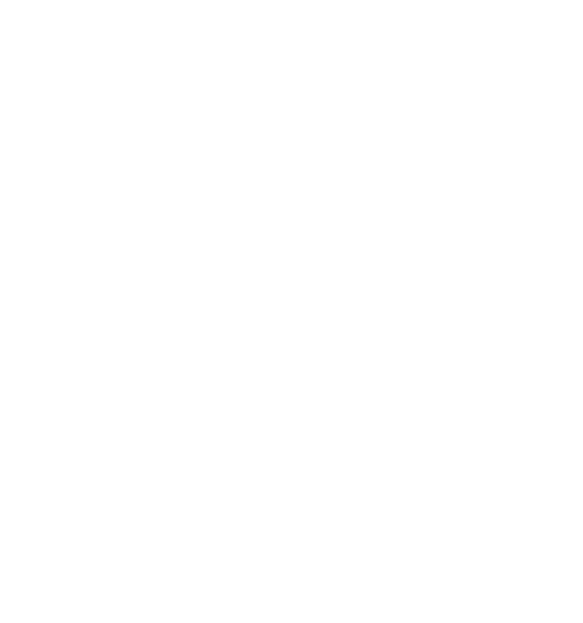

8.24e+00 | laplace: 7.37e-01 | model: 5.77e-01 | silh_0: 5.73e-02 | silh_1: 5.64e-02 | silh_10: 6.03e-02 | silh_100: 6.78e-02 | silh_101: 6.87e-02 | silh_102: 5.45e-02 | silh_103: 3.91e-02 | silh_104: 3.37e-02 | silh_105: 3.85e-02 | silh_106: 5.22e-02 | silh_107: 5.97e-02 | silh_108: 7.16e-02 | silh_109: 6.74e-02 | silh_11: 5.36e-02 | silh_110: 5.85e-02 | silh_111: 6.05e-02 | silh_112: 6.05e-02 | silh_113: 5.58e-02 | silh_114: 5.73e-02 | silh_115: 5.76e-02 | silh_116: 5.88e-02 | silh_117: 5.29e-02 | silh_118: 5.24e-02 | silh_119: 5.21e-02 | silh_12: 3.82e-02 | silh_13: 3.91e-02 | silh_14: 5.54e-02 | silh_15: 6.34e-02 | silh_16: 6.31e-02 | silh_17: 6.17e-02 | silh_18: 6.24e-02 | silh_19: 6.55e-02 | silh_2: 5.42e-02 | silh_20: 6.29e-02 | silh_21: 5.86e-02 | silh_22: 6.14e-02 | silh_23: 6.48e-02 | silh_24: 5.55e-02 | silh_25: 3.68e-02 | silh_26: 2.84e-02 | silh_27: 4.44e-02 | silh_28: 5.50e-02 | silh_29: 6.22e-02 | silh_3: 5.34e-02 | silh_30: 6.85e-02 | silh_31: 6.70e-02 | silh_32: 5.72e-

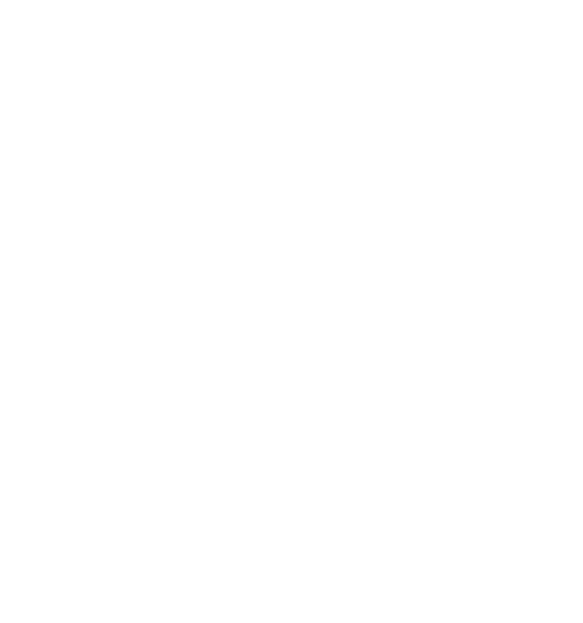

7.89e+00 | laplace: 5.29e-01 | model: 4.18e-01 | silh_0: 5.81e-02 | silh_1: 5.73e-02 | silh_10: 6.11e-02 | silh_100: 6.84e-02 | silh_101: 6.98e-02 | silh_102: 5.49e-02 | silh_103: 3.94e-02 | silh_104: 3.41e-02 | silh_105: 3.88e-02 | silh_106: 5.24e-02 | silh_107: 5.98e-02 | silh_108: 7.20e-02 | silh_109: 6.83e-02 | silh_11: 5.39e-02 | silh_110: 5.94e-02 | silh_111: 6.10e-02 | silh_112: 6.12e-02 | silh_113: 5.66e-02 | silh_114: 5.80e-02 | silh_115: 5.85e-02 | silh_116: 5.98e-02 | silh_117: 5.36e-02 | silh_118: 5.31e-02 | silh_119: 5.29e-02 | silh_12: 3.86e-02 | silh_13: 3.98e-02 | silh_14: 5.57e-02 | silh_15: 6.39e-02 | silh_16: 6.37e-02 | silh_17: 6.24e-02 | silh_18: 6.38e-02 | silh_19: 6.61e-02 | silh_2: 5.51e-02 | silh_20: 6.41e-02 | silh_21: 6.02e-02 | silh_22: 6.22e-02 | silh_23: 6.56e-02 | silh_24: 5.61e-02 | silh_25: 3.72e-02 | silh_26: 2.88e-02 | silh_27: 4.47e-02 | silh_28: 5.55e-02 | silh_29: 6.28e-02 | silh_3: 5.45e-02 | silh_30: 6.93e-02 | silh_31: 6.76e-02 | silh_32: 5.81e-

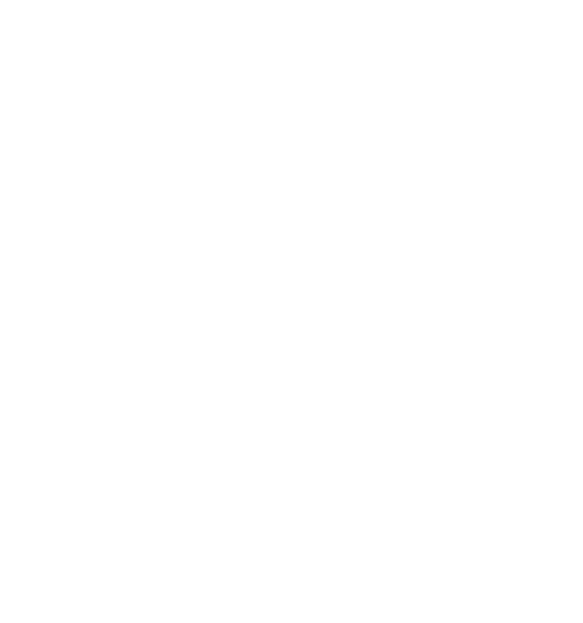

7.77e+00 | laplace: 4.39e-01 | model: 3.52e-01 | silh_0: 5.85e-02 | silh_1: 5.79e-02 | silh_10: 6.14e-02 | silh_100: 6.88e-02 | silh_101: 7.03e-02 | silh_102: 5.50e-02 | silh_103: 3.97e-02 | silh_104: 3.44e-02 | silh_105: 3.90e-02 | silh_106: 5.25e-02 | silh_107: 6.00e-02 | silh_108: 7.23e-02 | silh_109: 6.89e-02 | silh_11: 5.42e-02 | silh_110: 6.00e-02 | silh_111: 6.13e-02 | silh_112: 6.16e-02 | silh_113: 5.72e-02 | silh_114: 5.84e-02 | silh_115: 5.91e-02 | silh_116: 6.05e-02 | silh_117: 5.39e-02 | silh_118: 5.36e-02 | silh_119: 5.36e-02 | silh_12: 3.89e-02 | silh_13: 4.04e-02 | silh_14: 5.59e-02 | silh_15: 6.43e-02 | silh_16: 6.43e-02 | silh_17: 6.30e-02 | silh_18: 6.46e-02 | silh_19: 6.65e-02 | silh_2: 5.57e-02 | silh_20: 6.47e-02 | silh_21: 6.11e-02 | silh_22: 6.26e-02 | silh_23: 6.61e-02 | silh_24: 5.65e-02 | silh_25: 3.74e-02 | silh_26: 2.90e-02 | silh_27: 4.48e-02 | silh_28: 5.57e-02 | silh_29: 6.32e-02 | silh_3: 5.51e-02 | silh_30: 6.99e-02 | silh_31: 6.82e-02 | silh_32: 5.86e-

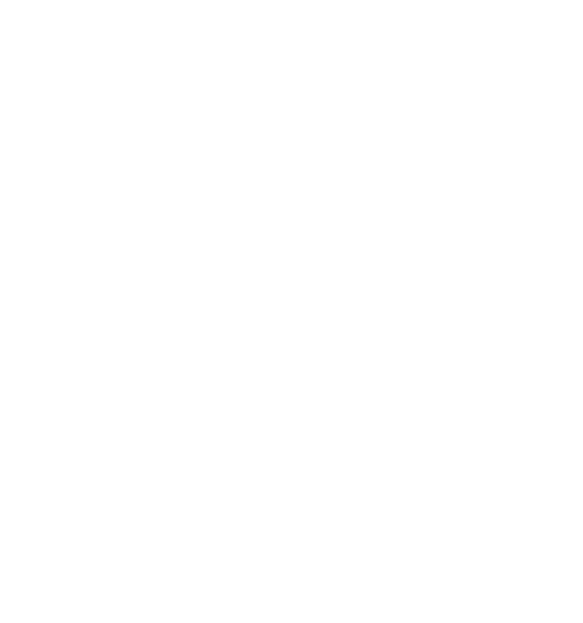

7.70e+00 | laplace: 3.83e-01 | model: 3.15e-01 | silh_0: 5.88e-02 | silh_1: 5.82e-02 | silh_10: 6.17e-02 | silh_100: 6.89e-02 | silh_101: 7.05e-02 | silh_102: 5.50e-02 | silh_103: 3.99e-02 | silh_104: 3.45e-02 | silh_105: 3.92e-02 | silh_106: 5.27e-02 | silh_107: 6.03e-02 | silh_108: 7.24e-02 | silh_109: 6.93e-02 | silh_11: 5.44e-02 | silh_110: 6.03e-02 | silh_111: 6.16e-02 | silh_112: 6.18e-02 | silh_113: 5.76e-02 | silh_114: 5.87e-02 | silh_115: 5.95e-02 | silh_116: 6.09e-02 | silh_117: 5.42e-02 | silh_118: 5.40e-02 | silh_119: 5.40e-02 | silh_12: 3.92e-02 | silh_13: 4.08e-02 | silh_14: 5.60e-02 | silh_15: 6.47e-02 | silh_16: 6.48e-02 | silh_17: 6.34e-02 | silh_18: 6.51e-02 | silh_19: 6.67e-02 | silh_2: 5.60e-02 | silh_20: 6.50e-02 | silh_21: 6.16e-02 | silh_22: 6.29e-02 | silh_23: 6.64e-02 | silh_24: 5.68e-02 | silh_25: 3.75e-02 | silh_26: 2.92e-02 | silh_27: 4.49e-02 | silh_28: 5.59e-02 | silh_29: 6.34e-02 | silh_3: 5.55e-02 | silh_30: 7.02e-02 | silh_31: 6.85e-02 | silh_32: 5.89e-

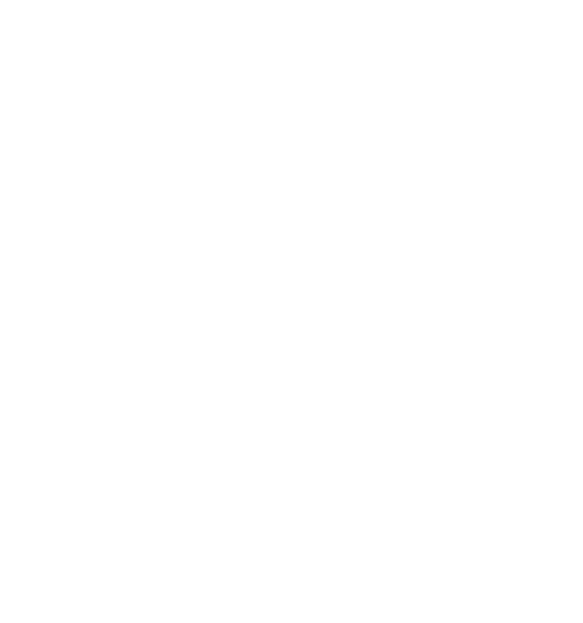

7.65e+00 | laplace: 3.42e-01 | model: 2.90e-01 | silh_0: 5.91e-02 | silh_1: 5.84e-02 | silh_10: 6.19e-02 | silh_100: 6.90e-02 | silh_101: 7.06e-02 | silh_102: 5.51e-02 | silh_103: 4.00e-02 | silh_104: 3.47e-02 | silh_105: 3.93e-02 | silh_106: 5.28e-02 | silh_107: 6.06e-02 | silh_108: 7.25e-02 | silh_109: 6.95e-02 | silh_11: 5.46e-02 | silh_110: 6.05e-02 | silh_111: 6.18e-02 | silh_112: 6.18e-02 | silh_113: 5.79e-02 | silh_114: 5.89e-02 | silh_115: 5.97e-02 | silh_116: 6.12e-02 | silh_117: 5.43e-02 | silh_118: 5.42e-02 | silh_119: 5.43e-02 | silh_12: 3.94e-02 | silh_13: 4.10e-02 | silh_14: 5.61e-02 | silh_15: 6.50e-02 | silh_16: 6.51e-02 | silh_17: 6.37e-02 | silh_18: 6.56e-02 | silh_19: 6.69e-02 | silh_2: 5.63e-02 | silh_20: 6.51e-02 | silh_21: 6.18e-02 | silh_22: 6.32e-02 | silh_23: 6.65e-02 | silh_24: 5.69e-02 | silh_25: 3.76e-02 | silh_26: 2.93e-02 | silh_27: 4.50e-02 | silh_28: 5.62e-02 | silh_29: 6.35e-02 | silh_3: 5.58e-02 | silh_30: 7.05e-02 | silh_31: 6.87e-02 | silh_32: 5.91e-

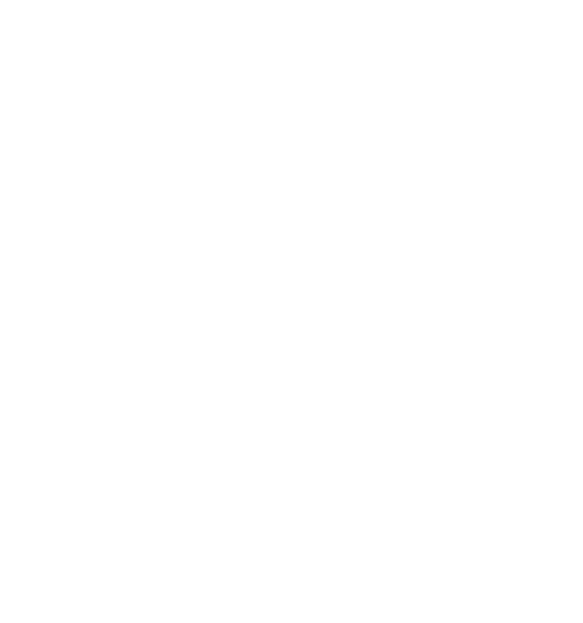

7.63e+00 | laplace: 3.17e-01 | model: 2.73e-01 | silh_0: 5.92e-02 | silh_1: 5.86e-02 | silh_10: 6.21e-02 | silh_100: 6.90e-02 | silh_101: 7.06e-02 | silh_102: 5.51e-02 | silh_103: 4.02e-02 | silh_104: 3.47e-02 | silh_105: 3.94e-02 | silh_106: 5.29e-02 | silh_107: 6.08e-02 | silh_108: 7.27e-02 | silh_109: 6.95e-02 | silh_11: 5.48e-02 | silh_110: 6.06e-02 | silh_111: 6.18e-02 | silh_112: 6.18e-02 | silh_113: 5.82e-02 | silh_114: 5.90e-02 | silh_115: 6.00e-02 | silh_116: 6.13e-02 | silh_117: 5.44e-02 | silh_118: 5.43e-02 | silh_119: 5.46e-02 | silh_12: 3.96e-02 | silh_13: 4.13e-02 | silh_14: 5.62e-02 | silh_15: 6.52e-02 | silh_16: 6.55e-02 | silh_17: 6.38e-02 | silh_18: 6.58e-02 | silh_19: 6.70e-02 | silh_2: 5.64e-02 | silh_20: 6.52e-02 | silh_21: 6.20e-02 | silh_22: 6.33e-02 | silh_23: 6.65e-02 | silh_24: 5.70e-02 | silh_25: 3.77e-02 | silh_26: 2.94e-02 | silh_27: 4.51e-02 | silh_28: 5.64e-02 | silh_29: 6.37e-02 | silh_3: 5.60e-02 | silh_30: 7.08e-02 | silh_31: 6.89e-02 | silh_32: 5.91e-

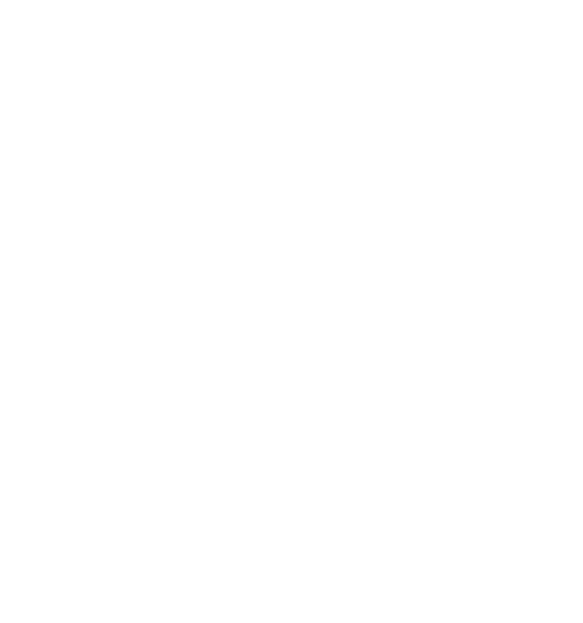

7.61e+00 | laplace: 3.04e-01 | model: 2.63e-01 | silh_0: 5.93e-02 | silh_1: 5.86e-02 | silh_10: 6.23e-02 | silh_100: 6.90e-02 | silh_101: 7.05e-02 | silh_102: 5.52e-02 | silh_103: 4.03e-02 | silh_104: 3.48e-02 | silh_105: 3.95e-02 | silh_106: 5.31e-02 | silh_107: 6.10e-02 | silh_108: 7.28e-02 | silh_109: 6.96e-02 | silh_11: 5.50e-02 | silh_110: 6.06e-02 | silh_111: 6.18e-02 | silh_112: 6.18e-02 | silh_113: 5.83e-02 | silh_114: 5.92e-02 | silh_115: 6.01e-02 | silh_116: 6.15e-02 | silh_117: 5.45e-02 | silh_118: 5.44e-02 | silh_119: 5.47e-02 | silh_12: 3.98e-02 | silh_13: 4.15e-02 | silh_14: 5.62e-02 | silh_15: 6.54e-02 | silh_16: 6.57e-02 | silh_17: 6.39e-02 | silh_18: 6.60e-02 | silh_19: 6.70e-02 | silh_2: 5.64e-02 | silh_20: 6.53e-02 | silh_21: 6.21e-02 | silh_22: 6.34e-02 | silh_23: 6.65e-02 | silh_24: 5.71e-02 | silh_25: 3.78e-02 | silh_26: 2.96e-02 | silh_27: 4.51e-02 | silh_28: 5.65e-02 | silh_29: 6.37e-02 | silh_3: 5.61e-02 | silh_30: 7.09e-02 | silh_31: 6.90e-02 | silh_32: 5.91e-

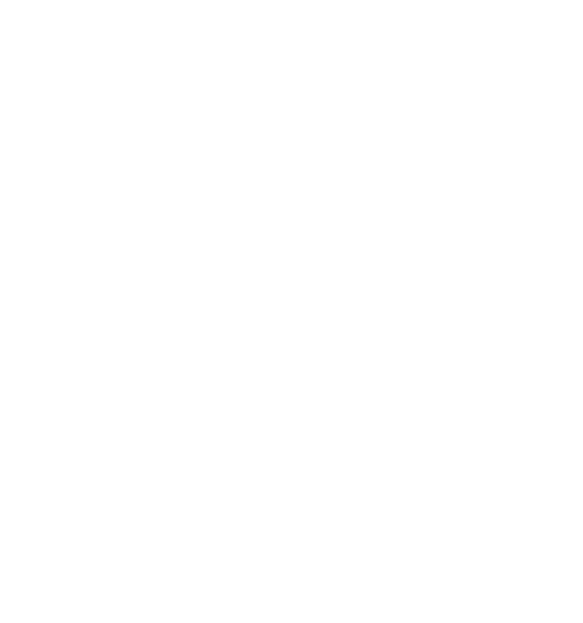

7.60e+00 | laplace: 2.95e-01 | model: 2.57e-01 | silh_0: 5.94e-02 | silh_1: 5.86e-02 | silh_10: 6.24e-02 | silh_100: 6.89e-02 | silh_101: 7.05e-02 | silh_102: 5.52e-02 | silh_103: 4.04e-02 | silh_104: 3.49e-02 | silh_105: 3.95e-02 | silh_106: 5.31e-02 | silh_107: 6.12e-02 | silh_108: 7.30e-02 | silh_109: 6.97e-02 | silh_11: 5.51e-02 | silh_110: 6.07e-02 | silh_111: 6.18e-02 | silh_112: 6.17e-02 | silh_113: 5.84e-02 | silh_114: 5.92e-02 | silh_115: 6.02e-02 | silh_116: 6.16e-02 | silh_117: 5.45e-02 | silh_118: 5.45e-02 | silh_119: 5.48e-02 | silh_12: 3.99e-02 | silh_13: 4.16e-02 | silh_14: 5.63e-02 | silh_15: 6.56e-02 | silh_16: 6.59e-02 | silh_17: 6.39e-02 | silh_18: 6.60e-02 | silh_19: 6.70e-02 | silh_2: 5.64e-02 | silh_20: 6.54e-02 | silh_21: 6.22e-02 | silh_22: 6.35e-02 | silh_23: 6.65e-02 | silh_24: 5.71e-02 | silh_25: 3.78e-02 | silh_26: 2.96e-02 | silh_27: 4.52e-02 | silh_28: 5.66e-02 | silh_29: 6.38e-02 | silh_3: 5.61e-02 | silh_30: 7.09e-02 | silh_31: 6.89e-02 | silh_32: 5.91e-

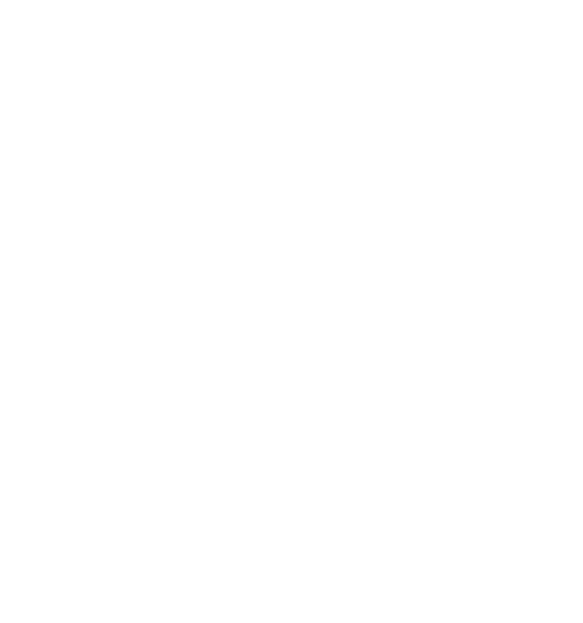

7.60e+00 | laplace: 2.89e-01 | model: 2.53e-01 | silh_0: 5.94e-02 | silh_1: 5.86e-02 | silh_10: 6.25e-02 | silh_100: 6.89e-02 | silh_101: 7.05e-02 | silh_102: 5.52e-02 | silh_103: 4.04e-02 | silh_104: 3.50e-02 | silh_105: 3.95e-02 | silh_106: 5.32e-02 | silh_107: 6.13e-02 | silh_108: 7.32e-02 | silh_109: 6.98e-02 | silh_11: 5.52e-02 | silh_110: 6.07e-02 | silh_111: 6.18e-02 | silh_112: 6.17e-02 | silh_113: 5.85e-02 | silh_114: 5.92e-02 | silh_115: 6.02e-02 | silh_116: 6.17e-02 | silh_117: 5.45e-02 | silh_118: 5.45e-02 | silh_119: 5.48e-02 | silh_12: 4.00e-02 | silh_13: 4.17e-02 | silh_14: 5.63e-02 | silh_15: 6.57e-02 | silh_16: 6.61e-02 | silh_17: 6.40e-02 | silh_18: 6.61e-02 | silh_19: 6.70e-02 | silh_2: 5.64e-02 | silh_20: 6.54e-02 | silh_21: 6.23e-02 | silh_22: 6.35e-02 | silh_23: 6.65e-02 | silh_24: 5.72e-02 | silh_25: 3.79e-02 | silh_26: 2.97e-02 | silh_27: 4.52e-02 | silh_28: 5.67e-02 | silh_29: 6.39e-02 | silh_3: 5.62e-02 | silh_30: 7.10e-02 | silh_31: 6.89e-02 | silh_32: 5.91e-

In [6]:
log.info('Begin consensus fit...')
fit_consensus(frames, base_smpl, camera, frustum, model_data, nohands, icp_count, naked, display)

with open(out, 'wb') as fp:
    pkl.dump({
        'v_personal': base_smpl.v_personal.r,
        'betas': base_smpl.betas.r,
    }, fp, protocol=2)

if obj_out is not None:
    base_smpl.pose[:] = 0
    vt = np.load('assets/basicModel_vt.npy')
    ft = np.load('assets/basicModel_ft.npy')
    mesh.write(obj_out, base_smpl.r, base_smpl.f, vt=vt, ft=ft)

log.info('Done.')

In [ ]:
def main():

    


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        'pose_file',
        type=str,
        help="File that contains poses")
    parser.add_argument(
        'masks_file',
        type=str,
        help="File that contains segmentations")
    parser.add_argument(
        'camera',
        type=str,
        help="pkl file that contains camera settings")
    parser.add_argument(
        'out',
        type=str,
        help="Out file path")
    parser.add_argument(
        '--obj_out', '-oo',
        default=None,
        help='obj out file name (optional)')
    parser.add_argument(
        '--num', '-n', default=120, type=int,
        help="Number of used frames")
    parser.add_argument(
        '--icp', '-i', default=3, type=int,
        help="ICP Iterations")
    parser.add_argument(
        '--model', '-m',
        default='vendor/smpl/models/basicmodel_m_lbs_10_207_0_v1.0.0.pkl',
        help='Path to SMPL model')
    parser.add_argument(
        '--first_frame', '-f', default=0, type=int,
        help="First frame to use")
    parser.add_argument(
        '--last_frame', '-l', default=2000, type=int,
        help="Last frame to use")
    parser.add_argument(
        '--nohands', '-nh',
        action='store_true',
        help="Exclude hands from optimization")
    parser.add_argument(
        '--naked', '-nk',
        action='store_true',
        help="Person wears (almost) no clothing")
    parser.add_argument(
        '--display', '-d',
        action='store_true',
        help="Enable visualization")

    args = parser.parse_args()

    main(args.pose_file, args.masks_file, args.camera, args.out, args.obj_out, args.num, args.icp, args.model,
         args.first_frame, args.last_frame, args.nohands, args.naked, args.display)
